In [1]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)
# GRAPHS_IMG_FILEPATH = "/Users/seth/development/01_deep-learning-from-scratch/images/02_fundamentals/graphs/"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TEST_ALL = False

# Boston data

In [4]:
from sklearn.datasets import load_boston

In [5]:
boston = load_boston()

In [6]:
data = boston.data
target = boston.target
features = boston.feature_names

# SciKit Learn Linear Regression

## Data prep

In [7]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## Regression

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [10]:
import matplotlib.pyplot as plt

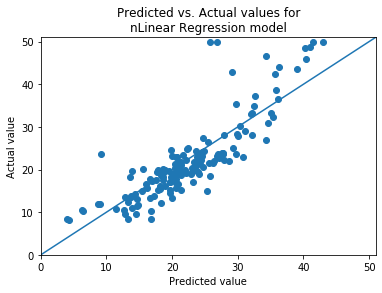

In [11]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nnLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(IMG_FILEPATH + "00_linear_real_pred_vs_actual.png");

## Testing changing feature

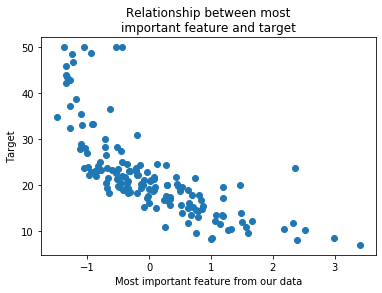

In [12]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target");
# plt.savefig(IMG_FILEPATH + "02_most_important_feature_vs_target.png")

Non linear relationship

## Model error

In [13]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [14]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5671 
Root mean squared error: 5.0476


In [15]:
import numpy as np
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

## Manual linear regression

In [16]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info

In [17]:
def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [18]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [19]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [20]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [21]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference).
    '''
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [22]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [23]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [24]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

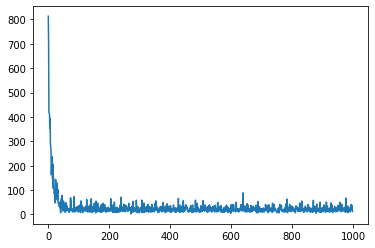

In [25]:
plt.plot(list(range(1000)), losses);

In [26]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [27]:
preds = predict(X_test, weights)

In [28]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5644 
Root mean squared error: 5.0497


In [29]:
np.round(y_test.mean(), 4)

22.0776

In [30]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

RMSE is 23% on average of y.

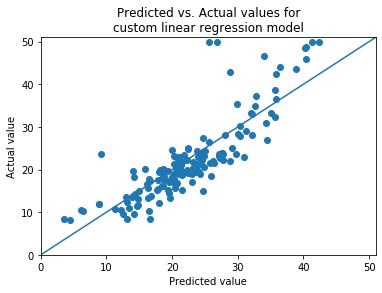

In [31]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(GRAPHS_IMG_FILEPATH + "01_linear_custom_pred_vs_actual.png");

In [32]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

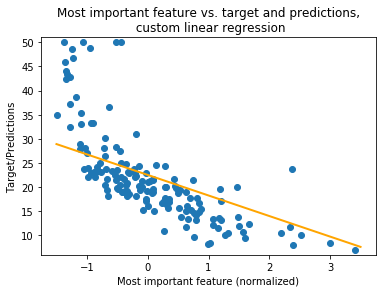

In [33]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression");
# plt.savefig(GRAPHS_IMG_FILEPATH + "03_most_important_feature_vs_predictions.png")

## Coefficients

In [34]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

In [35]:
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [36]:
np.round(weights['B'], 4)

array([[22.6312]])

In [37]:
np.round(lr.intercept_, 4)

array([22.6195])

Coefficients are the same in the SciKit Learn linear regression as in the "custom" linear regression.

## Theoretical relationship between most important feature and target

In [38]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [39]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

(6, 51)

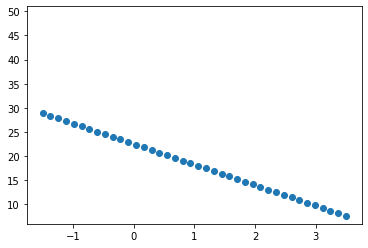

In [40]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
# plt.savefig(GRAPHS_IMG_FILEPATH + "/04_relationship_most_impt_feat_preds.png")

# Neural network regression

In [41]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

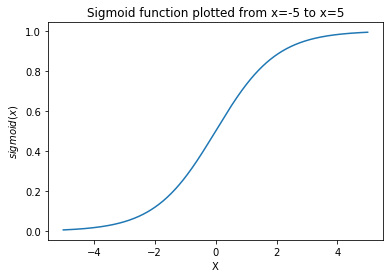

In [42]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)));
plt.title("Sigmoid function plotted from x=-5 to x=5")
plt.xlabel("X")
plt.ylabel("$sigmoid(x)$");
# plt.savefig(GRAPHS_IMG_FILEPATH + "05_sigmoid_function.png")

In [43]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    '''
    Initialize weights during the forward pass for step-by-step neural network model.
    '''
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [44]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    Compute the forward pass and the loss for the step-by-step 
    neural network model.     
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [45]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute the partial derivatives of the loss with respect to each of the parameters in the neural network.
    '''    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [46]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:
    '''
    Generate predictions from the step-by-step neural network model. 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [47]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [48]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [49]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

### Learning rate tuning

In [50]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [51]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [52]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [53]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

## Evaluating best model

In [54]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

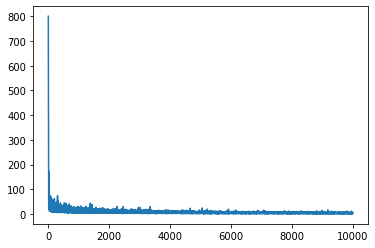

In [55]:
plt.plot(list(range(10000)), losses);

In [56]:
preds = predict(X_test, weights)

## Investigation of most important features

Most important combinations of features are the two with absolute values of greater than 9:

In [57]:
weights['W2']

array([[  6.8818],
       [  7.3908],
       [  5.632 ],
       [  7.2358],
       [  7.6253],
       [  6.754 ],
       [  3.3251],
       [  9.7287],
       [  5.6011],
       [-10.2469],
       [  5.5645],
       [  5.6762],
       [ -4.4088]])

These are at index 7 and index 9. Here are the combinations themselves:

In [58]:
weights['W1'][7]

array([-3.3532e+00, -4.6775e-01,  5.4810e-01, -8.8043e-02,  1.7536e+00,
       -5.3111e+00, -9.4313e-01, -5.8730e-01, -1.2341e-03,  1.1375e+00,
       -5.2801e-01,  1.1592e+00,  1.6007e+00])

In [59]:
weights['W1'][9]

array([-2.6785,  3.9213,  2.2398, -3.6323, -0.2241,  3.1889,  0.3231,
        0.4316, -1.9733,  0.2403, -1.4463, -0.5084,  1.5561])

In [60]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 2.5951 
Root mean squared error: 3.8851


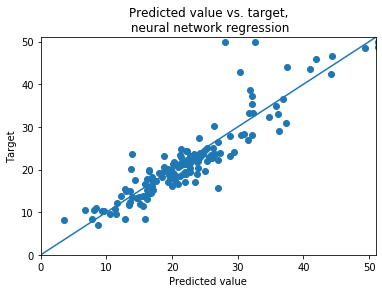

In [61]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target,\n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(GRAPHS_IMG_FILEPATH + "07_neural_network_regression_preds_vs_target.png");

In [62]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.5951

In [63]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

15.0943

## Theoretical relationship between most important feature and target

In [64]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

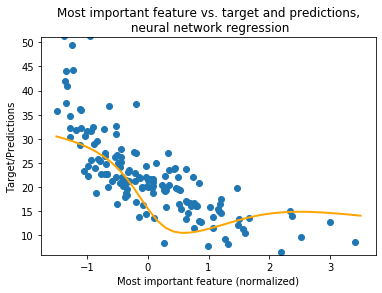

In [65]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n neural network regression");
# plt.savefig(GRAPHS_IMG_FILEPATH + "08_neural_network_regression_impt_feat_vs_preds.png")